# ERP peak analysis

Extract the study-relevant ERP peak subjectwise (e.g. one value per subject) and statistically test them. 
* Example RQ: On which ERP-peaks do we find major difference between the conditions?

In [4]:
# general purpose
import numpy as np
import pandas as pd

# i/O
from scipy import io
from pathlib import Path
import datetime

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# testing
import unittest

# EEG stuff
import mne
import osfclient 
import mne_bids 
from mne_bids import (BIDSPath, read_raw_bids)
import scipy

# EEG utils 
import ccs_eeg_utils
import ccs_eeg_semesterproject

import configuration

In [5]:
# mne.set_log_level('WARNING')

## getting ERPs

P3: The task for the participants was to press the letters A,B,C,D,E when the corresponding letter was shown as a stimupli randomly with $p = 0.2$. One letter was designated the target for a given block of trials, and the other 4 letters were non-distractors. Thus, the probability of the distractor category was $0.2$, but the same physical stimulus served as a target in some blocks and a nontarget in others. Participants responded whether the letter presented on each trial was the target or a non-target for that block. There were 34 participants.

We can cross-check the results with the published results:
- time window of stat. significant difference: $253.91 - 664.06$
- recommended measurement window: $300 - 600$

[Tutorial: EEG analysis - Event-Related Potentials (ERPs)](https://mne.tools/stable/auto_tutorials/evoked/30_eeg_erp.html), [Tutorial: Visualizing Evoked data](https://mne.tools/stable/auto_tutorials/evoked/20_visualize_evoked.html)

TODO:
- [x] should be able to detect subject 9, 30, 35 and 40 for TC
- [x] nicer dateframe with better columns also for vis
- [ ] why is it wrong???
  - [x] apply 20Hz lowpass on all measures which could be influenced by high-frequency noise
  - [ ] and without!
  - [x] a good range for `get_peak(tmin, tmax, mode='pos', return_amplitude=True)`
  - [ ] reject subjects based on: TC less than 50% rare trails remaining after artifact rejection, AR: over 25% of trials rejected due to artifact
- [x] difference waveform
- [ ] t-test
  - [ ] time window for mean based on literature
- [x] violin plot with the peak latency/amplitude of target vs distractor

possibly:
- [ ] get multiple channels for significance comparison
- [ ] Global field power [1][2][3] is, generally speaking, a measure of agreement of the signals picked up by all sensors across the entire scalp, [see](https://mne.tools/stable/auto_tutorials/evoked/30_eeg_erp.html#global-field-power-gfp)
  - literature says it is mainly `Pz` and `Cz`, but is it?
- [ ] plotting signal traces, image plots of evoked objects

In [6]:
subject_ids = [path.stem.replace('sub-', '') for path in Path(configuration.fname.bids_root).glob('sub-*')]

# columns_evoked = ['subject_id', 
#                   'no_trials', 'accuracy', # I can check this
#                   'avg_peak_value_target', 'avg_peak_value_distractor',
#                   'avg_peak_time_target', 'avg_peak_time_distractor', # I can use it to compare it to the literature
#                   'target_evd_path', 'distractor_evd_path', # paths to saved evoked data
#                   'mean_response_time', ]
# evoked_metadata_dump = []

# grand dataframes with all the features
## per epoch: one df to save them all # TODO
# epochs_df_columns = ['subject_id', 'epoch_no', 'peak_latency', 'peak_amplitude', 'condition', 'response_time'] # channel
# epochs_df = pd.DataFrame(columns=epochs_df_columns)
## per subject * (target/distractors): one df to save all
subjects_df_columns = ['subject_id', 'accuracy', 'trial_accuracy','channel', 'no_trials', 'avg_peak_latency', 'avg_peak_amplitude', 'condition', 'avg_response_time', 'mean_amplitude'] # channel
subjects_df = pd.DataFrame(columns=subjects_df_columns)

# raw data
epochs_dump = []
evoked_target_dump = []
evoked_distractor_dump = []

excluded_subjects = []

visualize = True  # debug

for subject in subject_ids:
    # epochs_df_local = pd.DataFrame(index=[0], columns=epochs_df_columns)
    subjects_df_local = pd.DataFrame(index=[0], columns=subjects_df_columns)

    # visualize every fifth subject
    if np.random.randint(1, 6) == 5:
        visualize = True

    ##################
    ### Processing ###
    ##################
    # read data
    bids_path = BIDSPath(subject=subject, task="P3", session="P3",
                         datatype='eeg', suffix='eeg',
                         root=configuration.fname.bids_root)

    raw = read_raw_bids(bids_path)
    ccs_eeg_utils.read_annotations_core(bids_path, raw)
    raw.load_data()

    # add channel locations
    raw.set_channel_types({'HEOG_left': 'eog'})
    raw.set_channel_types({'HEOG_right': 'eog'})
    raw.set_channel_types({'VEOG_lower': 'eog'})
    raw.set_montage('standard_1020', match_case=False)


    # downsample
    raw.resample(configuration.resampling_freq)

    # filter
    raw = raw.filter(l_freq=configuration.high_pass_cutoff_freq,
                     h_freq=None,
                     fir_design='firwin',
                     verbose=True)
    raw = raw.filter(l_freq=None,
                     h_freq=configuration.low_pass_cutoff_freq,
                     fir_design='firwin',
                     verbose=True)

    # bad channels
    annotations, badChannels = ccs_eeg_semesterproject.load_precomputed_badData(bids_root=configuration.fname.bids_root,
                                                                                subject_id=subject,
                                                                                task='P3')
        
    print(f"Those are the bad channels read: {badChannels}, {np.shape(badChannels)} for subject {subject}")
    if np.size(badChannels) > 0:
        if np.size(badChannels) == 1: # subject 35 - why?
            badChannels_named = raw.ch_names[badChannels]
            print(badChannels_named)
            raw.info['bads'].extend([badChannels_named]) # is that correct?
        else:
            badChannels_named = [raw.ch_names[i] for i in badChannels]
            print(badChannels_named)
            raw.info['bads'].extend(badChannels_named) # is that correct?
        raw.interpolate_bads()

    # ICA
    ica, badcomp = ccs_eeg_semesterproject.load_precomputed_ica(bids_root=configuration.fname.bids_root,
                                                                subject_id=subject,
                                                                task='P3')
    ica = ccs_eeg_semesterproject.add_ica_info(raw,ica) # to plot the ICA 
    ica.exclude = badcomp
    ica.apply(raw)

    # check the excluded
    # if visualize:
    #    ica.plot_overlay(raw, exclude=badcomp)

    # rereference
    raw.set_eeg_reference(['P9', 'P10'])

    # event stats - if the stimulus is not answered correctly, it is wrong
    idx_all_responses = np.where('response' in raw.annotations.description)
    n_correct_resp, n_wrong_resp = 0, 0
    n_correct_resp_rare, n_wrong_resp_rare = 0, 0
    n_correct_resp_freq, n_wrong_resp_freq = 0, 0
    response_times_rare, response_times_freq = [], []
    for i, annotation in enumerate(raw.annotations):
        if 'stimulus' in annotation['description']:
            if raw.annotations[i +1]['description'] == 'response:201':
                n_correct_resp += 1
                start_stimulus = annotation['onset']
                start_response = raw.annotations[i+1]['onset']
                response_time = start_response - start_stimulus - configuration.monitor_delay
                if annotation['description'][-1] == annotation['description'][-2]:
                    # we are in the rare condition
                    n_correct_resp_rare +=1
                    response_times_rare.append(response_time)
                else:
                    n_correct_resp_freq +=1
                    response_times_freq.append(response_time)
            elif raw.annotations[i +1]['description'] == 'response:202':
                n_wrong_resp += 1
                if annotation['description'][-1] == annotation['description'][-2]:
                    # we are in the rare condition
                    n_wrong_resp_rare +=1
                else:
                    n_wrong_resp_freq += 1
            else:
                n_wrong_resp += 1
                if annotation['description'][-1] == annotation['description'][-2]:
                    # we are in the rare condition
                    n_wrong_resp_rare +=1
                else:
                    n_wrong_resp_freq +=1

    avg_response_time_rare = np.mean(response_times_rare)
    avg_response_time_freq = np.mean(response_times_freq)
    no_trials = (n_wrong_resp+n_correct_resp)
    accuracy = (n_correct_resp / (no_trials)) *100
    accuracy_condition_rare = n_correct_resp_rare/(n_correct_resp_rare+n_wrong_resp_rare) *100
    accuracy_condition_freq = n_correct_resp_freq/(n_correct_resp_freq+n_wrong_resp_freq) *100

    # reject subject if the error rate is > 25%
    if (accuracy) < 75:
        excluded_subjects.append((subject,f"ACC: The accuracy was only {accuracy} %"))
        print(f"Subject {subject} was excluded due to an error rate of {accuracy} %.")
        continue
    # reject based on fewer than 50% of trials remained in any single experimental condition
    elif (accuracy_condition_rare) < 50:
        excluded_subjects.append((subject,f"ACC_T: The accuracy of the rare condition was only {accuracy_condition_rare} %"))
        print(f"Subject {subject} was excluded due to an error rate of {accuracy_condition_rare} %.")
        continue
    elif (accuracy_condition_freq) < 50:
        excluded_subjects.append((subject,f"ACC_T: The accuracy of the frequent condition was only {accuracy_condition_freq} %"))
        print(f"Subject {subject} was excluded due to an error rate of {accuracy_condition_freq} %.") 
        continue

    ##############
    ### Events ###
    ##############
    # convert annotations to events
    evts, evts_dict = mne.events_from_annotations(raw)
    wanted_keys = [e for e in evts_dict.keys() if "stimulus" in e]
    evts_dict_stim = dict((k, evts_dict[k])
                          for k in wanted_keys if k in evts_dict)

    # epochs = (n_epochs, n_channels, n_times)
    epochs = mne.Epochs(raw, evts, evts_dict_stim,
                        tmin=configuration.tmin, tmax=configuration.tmax,
                        reject_by_annotation=True,
                        # TODO reject by amplitude
                        baseline=(None,0),
                        preload=True,  # makes life easier
                        picks=configuration.pick)

    # shift epochs with monitor delay
    epochs.shift_time(-configuration.monitor_delay)

    # exclude wrong trials
    wrong_trials = np.where(raw.annotations.description == 'response:202')
    for idx in wrong_trials:
        raw.annotations.append(onset=raw.annotations[idx].onset,
                               duration=raw.annotations[idx].duration,
                               description='bad-response')

    # TODO # participants were excluded from the error-related negativity (ERN) analysis if fewer than 6 error trials remained after artifact rejection
    # TODO # reject based on amplitude: https://mne.tools/stable/auto_tutorials/preprocessing/20_rejecting_bad_data.html#tut-reject-epochs-section

    print([(i, a_) for i, a_ in enumerate(epochs.drop_log) if a_ != ()])

    # if visualize:
    #   epochs.plot(block=True)
    #   target and distractor seperately? # order=sort_order -> latency/intensity pattern
    #   epochs.plot_image()

    # TODO # include stimulus and response etc. in the epochs
#     epochs.metadata['stimulus'] =
#     metadata, events, event_id = mne.epochs.make_metadata(
#         events=evts, event_id=evts_dict_stim,
#         tmin=-0.2, tmax=0.8,
#         sfreq=raw.info['sfreq'])

    # save
    df_epochs_local = epochs.to_data_frame(index=['condition', 'epoch', 'time'],
                              time_format=None,)
    df_epochs_local['subject_id'] = subject
    epochs_dump.append(df_epochs_local)

    # save epochs in folder structure for time-frequency analysis
    filepath_epoch = f"{configuration.path_results}/epochs/{subject}-epo.fif" # TODO: in bids structure
    epochs.save(filepath_epoch, overwrite=True)

    ##############
    ### Evoked ###
    ##############
    # target vs distractor (n_channels, n_times)
    # TODO # equalize_event_counts
    target = epochs[[f"stimulus:{k}{k}" for k in [1, 2, 3, 4, 5]]].average()
    distractor = epochs[[f"stimulus:{k}{j}" for k in [1, 2, 3, 4, 5] for j in [1, 2, 3, 4, 5] if k != j]].average()

    # if visualize:
    #   mne.viz.plot_compare_evokeds([target, distractor])

    # save evoked objects for later combination
    evoked_target_dump.append(target)
    evoked_distractor_dump.append(distractor)

    # further meta-data and data saving
    target_ch = target.pick_channels(ch_names = [configuration.pick])
    distractor_ch = distractor.pick_channels(ch_names = [configuration.pick])
    filepath_target = f"{configuration.path_results}/{subject}_target_evoked-ave.fif"
    filepath_distractor = f"{configuration.path_results}/{subject}_distractor_evoked-ave.fif"
    # mne.write_evokeds(filepath_target, target_ch)
    # mne.write_evokeds(filepath_distractor, distractor_ch)
    # evoked_local['target_erp'] = filepath_target
    # evoked_local['distractor_erp'] = filepath_distractor

    #############
    ### Stats ###
    #############
    # mean_response_time, response_times_corr,   accuracy_condition_rare ,accuracy_condition_rare ,    
    # avg_response_time_rare, response_times_rare,  avg_response_time_freq , response_times_freq
    # for event in epochs.events:

    # for each subject and each condition
    target_filt = target_ch.filter(l_freq=None,
                                    h_freq=20,
                                    fir_design='firwin')
    distractor_filt = distractor_ch.filter(l_freq=None,
                                        h_freq=20,
                                        fir_design='firwin')

    subjects_df_local_target = pd.DataFrame(index=[0], columns=subjects_df_columns)
    subjects_df_local_target['condition'] = 'target'
    subjects_df_local_target['trial_accuracy'] = accuracy_condition_rare
    subjects_df_local_target['avg_response_time'] = avg_response_time_rare
    _, subjects_df_local_target['avg_peak_latency'], subjects_df_local_target['avg_peak_amplitude'] = target_filt.get_peak(tmin=0.25, tmax=0.45, mode='pos', return_amplitude=True)
    target_recommended_window = target_ch.copy().crop(tmin=configuration.recommended_tmin,
                                                      tmax=configuration.recommended_tmax)
    subjects_df_local_target['mean_amplitude'] = np.mean(target_recommended_window.data)

    subjects_df_local_distractor = pd.DataFrame(index=[0], columns=subjects_df_columns)
    subjects_df_local_distractor['condition'] = 'distractor'
    subjects_df_local_distractor['trial_accuracy'] = accuracy_condition_freq
    subjects_df_local_distractor['avg_response_time'] = avg_response_time_freq
    _, subjects_df_local_distractor['avg_peak_latency'], subjects_df_local_distractor['avg_peak_amplitude'] = distractor_filt.get_peak(tmin=0.25, tmax=0.45, mode='pos', return_amplitude=True)
    distractor_recommended_window = distractor_ch.copy().crop(tmin=configuration.recommended_tmin,
                                                              tmax=configuration.recommended_tmax)
    subjects_df_local_distractor['mean_amplitude'] = np.mean(distractor_recommended_window.data)

    subjects_df_local = pd.concat([subjects_df_local_target, subjects_df_local_distractor], ignore_index=True)

    # the same for all conditions
    # epochs_df_local['subject_id'] = int(subject)

    subjects_df_local['subject_id'] = int(subject)
    subjects_df_local['accuracy'] = accuracy
    subjects_df_local['no_trials'] = no_trials
    subjects_df_local['channel'] = configuration.pick

    ############
    ### Save ###
    ############
    # append local dataframe at the end of the dataframe
    # epoch_df = pd.concat(epochs_df_local, ignore_index = True)
    subjects_df = pd.concat([subjects_df, subjects_df_local], ignore_index=True)

# wrap up
# evoked_metadata = pd.concat(evoked_metadata_dump, ignore_index=True)
evoked_target_combined = mne.combine_evoked(evoked_target_dump, weights='nave')
evoked_distractor_combined = mne.combine_evoked(evoked_distractor_dump, weights='nave')
epochs = pd.concat(epochs_dump)

Reading /home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/Data/p3/sub-027/ses-P3/eeg/sub-027_ses-P3_task-P3_eeg.fdt
Reading events from Data/p3/sub-027/ses-P3/eeg/sub-027_ses-P3_task-P3_events.tsv.
The event "response" refers to multiple event values. Creating hierarchical event names.
    Renaming event: response -> response/202
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/202
    Renaming event: response -> response/201
    Renaming event: response

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-027_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-027_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


Reading channel info from Data/p3/sub-027/ses-P3/eeg/sub-027_ses-P3_task-P3_channels.tsv.
Reading 0 ... 366591  =      0.000 ...   357.999 secs...


/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-027/ses-P3/eeg/sub-027_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-027/ses-P3/eeg/sub-027_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 027
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events an

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-027/ses-P3/eeg/sub-027_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


0 bad epochs dropped
[(0, ('IGNORED',)), (2, ('IGNORED',)), (4, ('IGNORED',)), (6, ('IGNORED',)), (8, ('IGNORED',)), (10, ('IGNORED',)), (12, ('IGNORED',)), (14, ('IGNORED',)), (16, ('IGNORED',)), (18, ('IGNORED',)), (20, ('IGNORED',)), (22, ('IGNORED',)), (24, ('IGNORED',)), (26, ('IGNORED',)), (28, ('IGNORED',)), (30, ('IGNORED',)), (32, ('IGNORED',)), (34, ('IGNORED',)), (36, ('IGNORED',)), (38, ('IGNORED',)), (40, ('IGNORED',)), (42, ('IGNORED',)), (44, ('IGNORED',)), (46, ('IGNORED',)), (48, ('IGNORED',)), (50, ('IGNORED',)), (52, ('IGNORED',)), (54, ('IGNORED',)), (56, ('IGNORED',)), (58, ('IGNORED',)), (60, ('IGNORED',)), (62, ('IGNORED',)), (64, ('IGNORED',)), (66, ('IGNORED',)), (68, ('IGNORED',)), (70, ('IGNORED',)), (72, ('IGNORED',)), (74, ('IGNORED',)), (76, ('IGNORED',)), (78, ('IGNORED',)), (80, ('IGNORED',)), (82, ('IGNORED',)), (84, ('IGNORED',)), (86, ('IGNORED',)), (88, ('IGNORED',)), (90, ('IGNORED',)), (92, ('IGNORED',)), (94, ('IGNORED',)), (96, ('IGNORED',)), (98

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-006_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-006_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-006/ses-P3/eeg/sub-006_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-006/ses-P3/eeg/sub-006_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 006
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-006/ses-P3/eeg/sub-006_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-004_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-004_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


Subject 006 was excluded due to an error rate of 12.5 %.
Reading /home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/Data/p3/sub-004/ses-P3/eeg/sub-004_ses-P3_task-P3_eeg.fdt
Reading events from Data/p3/sub-004/ses-P3/eeg/sub-004_ses-P3_task-P3_events.tsv.
The event "response" refers to multiple event values. Creating hierarchical event names.
    Renaming event: response -> response/202
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming eve

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-004/ses-P3/eeg/sub-004_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Data/p3/sub-004/ses-P3/eeg/sub-004_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 004
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-004/ses-P3/eeg/sub-004_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (2, ('IGNORED',)), (4, ('IGNORED',)), (6, ('IGNORED',)), (8, ('IGNORED',)), (10, ('IGNORED',)), (12, ('IGNORED',)), (14, ('IGNORED',)), (16, ('IGNORED',)), (18, ('IGNORED',)), (20, ('IGNORED',)), (22, ('IGNORED',)), (24, ('IGNORED',)), (26, ('IGNORED',)), (28, ('IGNORED',

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-022_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-022_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-022/ses-P3/eeg/sub-022_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-022/ses-P3/eeg/sub-022_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 022
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-022/ses-P3/eeg/sub-022_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-002_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-002_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
The event "stimulus" refers to multiple event values. Creating hierarchical event names.
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/44
    Renaming event: sti

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-002/ses-P3/eeg/sub-002_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-002/ses-P3/eeg/sub-002_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 002
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-002/ses-P3/eeg/sub-002_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-019_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-019_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-019/ses-P3/eeg/sub-019_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-019/ses-P3/eeg/sub-019_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 019
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-019/ses-P3/eeg/sub-019_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)), (29, ('IGNORED',)), (31, ('IGNORED',)), (33, ('IGNORED',)), (35, ('IGNORED',)), (37, ('IGNORED',)), (39, ('IGNORED',)), (41, ('IGNORED',)), (43, ('IGNORED',)), (45, ('IGNORED',)), (47, ('IGNORED',)), (49, ('IGNORED',)), (51, ('IGNORED',)), (53, ('IGNORED',)), (55, ('IGNORED',)), (57, ('IGNORED',)), (59, ('IGNORED',)), (61, ('IGNORED',)), (63, ('IGNORED',)), (65, ('IGNORED',)), (67, ('IGNORED',)), (69, ('IGNORED',)), (71, ('IGNORED',)), (73, ('IGNORED',)), (75, ('IGNORED',)), (77, ('IGNORED',)), (79, ('IGNORED',)), (81, ('IGNORED'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-032_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-032_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-032/ses-P3/eeg/sub-032_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-032/ses-P3/eeg/sub-032_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 032
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-032/ses-P3/eeg/sub-032_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-023_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-023_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-023/ses-P3/eeg/sub-023_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-023/ses-P3/eeg/sub-023_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 023
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events an

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-023/ses-P3/eeg/sub-023_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


0 bad epochs dropped
[(0, ('IGNORED',)), (2, ('IGNORED',)), (4, ('IGNORED',)), (6, ('IGNORED',)), (8, ('IGNORED',)), (10, ('IGNORED',)), (12, ('IGNORED',)), (14, ('IGNORED',)), (16, ('IGNORED',)), (18, ('IGNORED',)), (20, ('IGNORED',)), (22, ('IGNORED',)), (24, ('IGNORED',)), (26, ('IGNORED',)), (28, ('IGNORED',)), (30, ('IGNORED',)), (32, ('IGNORED',)), (34, ('IGNORED',)), (36, ('IGNORED',)), (38, ('IGNORED',)), (40, ('IGNORED',)), (42, ('IGNORED',)), (44, ('IGNORED',)), (46, ('IGNORED',)), (48, ('IGNORED',)), (50, ('IGNORED',)), (52, ('IGNORED',)), (54, ('IGNORED',)), (56, ('IGNORED',)), (58, ('IGNORED',)), (60, ('IGNORED',)), (62, ('IGNORED',)), (64, ('IGNORED',)), (66, ('IGNORED',)), (68, ('IGNORED',)), (70, ('IGNORED',)), (72, ('IGNORED',)), (74, ('IGNORED',)), (76, ('IGNORED',)), (78, ('IGNORED',)), (80, ('IGNORED',)), (82, ('IGNORED',)), (84, ('IGNORED',)), (86, ('IGNORED',)), (88, ('IGNORED',)), (90, ('IGNORED',)), (92, ('IGNORED',)), (94, ('IGNORED',)), (96, ('IGNORED',)), (98

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-018_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-018_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: response -> response/201
    Renaming event: response -> response/202
The event "stimulus" refers to multiple event values. Creating hierarchical event names.
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-018/ses-P3/eeg/sub-018_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-018/ses-P3/eeg/sub-018_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 018
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events an

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-018/ses-P3/eeg/sub-018_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)), (29, ('IGNORED',)), (31, ('IGNORED',)), (33, ('IGNORED',)), (35, ('IGNORED',)), (37, ('IGNORED',)), (39, ('IGNORED',)), (41, ('IGNORED',)), (43, ('IGNORED',)), (45, ('IGNORED',)), (47, ('IGNORED',)), (49, ('IGNORED',)), (51, ('IGNORED',)), (53, ('IGNORED',)), (55, ('IGNORED',)), (57, ('IGNORED',)), (59, ('IGNORED',)), (61, ('IGNORED',)), (63, ('IGNORED',)), (65, ('IGNORED',)), (67, ('IGNORED',)), (69, ('IGNORED',)), (71, ('IGNORED',)), (73, ('IGNORED',)), (75, ('IGNORED',)), (77, ('IGNORED',)), (79, ('IGNORED',)), (81, ('IGNORED',)), (83, ('IGNORED',)), (85, ('IGNORED',)), (87, ('IGNORED',)), (89, ('IGNORED',)), (91, ('IGNORED',)), (93, ('IGNORED',)), (95, ('IGNORED',)), (97,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-038_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-038_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
The event "stimulus" refers to multiple event values. Creating hierarchical event names.
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/34
    Renaming event: stim

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-038/ses-P3/eeg/sub-038_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-038/ses-P3/eeg/sub-038_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 038
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-038/ses-P3/eeg/sub-038_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-020_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-020_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-020/ses-P3/eeg/sub-020_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-020/ses-P3/eeg/sub-020_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 020
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-020/ses-P3/eeg/sub-020_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)), (29, ('IGNORED',)), (31, ('IGNORED',)), (33, ('IGNORED',)), (35, ('IGNORED',)), (37, ('IGNORED',)), (39, ('IGNORED',)), (41, ('IGNORED',)), (43, ('IGNORED',)), (45, ('IGNORED',)), (47, ('IGNORED',)), (49, ('IGNORED',)), (51, ('IGNORED',)), (53, ('IGNORED',)), (55, ('IGNORED',)), (57, ('IGNORED',)), (59, ('IGNORED',)), (61, ('IGNORED',)), (63, ('IGNORED',)), (65, ('IGNORED',)), (67, ('IGNORED',)), (69, ('IGNORED',)), (71, ('IGNORED',)), (73, ('IGNORED',)), (75, ('IGNORED',)), (77, ('IGNORED',)), (79, ('IGNORED',)), (81, ('IGNORED',)), (83, ('IGNORED',)), (85, ('IGNORED',)), (87, ('IGNORED',)), (89, ('IGNORED',)), (91, ('IGNORED',)), (93, ('IGNORED',)), (95, ('IGNORED',)), (97,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-003_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-003_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renami

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-003/ses-P3/eeg/sub-003_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-003/ses-P3/eeg/sub-003_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 003
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-003/ses-P3/eeg/sub-003_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-009_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-009_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/202
The event "stimulus" refers to multiple event values. Creating hierarchical event names.
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/41
    Renaming event: sti

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-009/ses-P3/eeg/sub-009_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-009/ses-P3/eeg/sub-009_ses-P3_task-P3_
Those are the bad channels read: [10 26], (2,) for subject 009
['PO3', 'P10']
Interpolating bad channels
    Automatic origin fit: head of radius 97.5 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 4 ICA components
    Projecting back using 28 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-035_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-035_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-035/ses-P3/eeg/sub-035_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-035/ses-P3/eeg/sub-035_ses-P3_task-P3_
Those are the bad channels read: 10, () for subject 035
PO3
Interpolating bad channels
    Automatic origin fit: head of radius 97.5 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Applying ICA to Raw instance
    Transforming to ICA space (29 components)
    Zeroing out 2 ICA components
    Projecting back using 29 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-031_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-031_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-031/ses-P3/eeg/sub-031_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-031/ses-P3/eeg/sub-031_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 031
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-031/ses-P3/eeg/sub-031_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)), (29, ('IGNORED',)), (31, ('IGNORED',)), (33, ('IGNORED',)), (35, ('IGNORED',)), (37, ('IGNORED',)), (39, ('IGNORED',)), (41, ('IGNORED',)), (43, ('IGNORED',)), (45, ('IGNORED',)), (47, ('IGNORED',)), (49, ('IGNORED',)), (51, ('IGNORED',)), (53, ('IGNORED',)), (55, ('IGNORED',)), (57, ('IGNORED',)), (59, ('IGNORED',)), (61, ('IGNORED',)), (63, ('IGNORED',)), (65, ('IGNORED',)), (67, ('IGNORED',)), (69, ('IGNORED',)), (71, ('IGNORED',)), (73, ('IGNORED',)), (75, ('IGNORED',)), (77, ('IGNORED',)), (79, ('IGNORED',)), (81, ('IGNORED',)), (83, ('IGNORED',)), (85, ('IGNORED',)), (87, ('IGNORED',)), (89, ('IGNORED',)), (91, ('IGNORED',)), (93, ('IGNORED',)), (95, ('IGNORED',)), (97,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-040_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-040_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


The event "stimulus" refers to multiple event values. Creating hierarchical event names.
    Renaming event: stimulus -> stimulus/11
    Renaming event: stimulus -> stimulus/14
    Renaming event: stimulus -> stimulus/14
    Renaming event: stimulus -> stimulus/13
    Renaming event: stimulus -> stimulus/12
    Renaming event: stimulus -> stimulus/11
    Renaming event: stimulus -> stimulus/13
    Renaming event: stimulus -> stimulus/11
    Renaming event: stimulus -> stimulus/15
    Renaming event: stimulus -> stimulus/15
    Renaming event: stimulus -> stimulus/15
    Renaming event: stimulus -> stimulus/14
    Renaming event: stimulus -> stimulus/11
    Renaming event: stimulus -> stimulus/14
    Renaming event: stimulus -> stimulus/14
    Renaming event: stimulus -> stimulus/15
    Renaming event: stimulus -> stimulus/12
    Renaming event: stimulus -> stimulus/11
    Renaming event: stimulus -> stimulus/15
    Renaming event: stimulus -> stimulus/11
    Renaming event: stimulus ->

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-040/ses-P3/eeg/sub-040_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-040/ses-P3/eeg/sub-040_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 040
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-040/ses-P3/eeg/sub-040_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-012_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-012_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-012/ses-P3/eeg/sub-012_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-012/ses-P3/eeg/sub-012_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 012
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events an

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-012/ses-P3/eeg/sub-012_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)), (29, ('IGNORED',)), (31, ('IGNORED',)), (33, ('IGNORED',)), (35, ('IGNORED',)), (37, ('IGNORED',)), (39, ('IGNORED',)), (41, ('IGNORED',)), (43, ('IGNORED',)), (45, ('IGNORED',)), (47, ('IGNORED',)), (49, ('IGNORED',)), (51, ('IGNORED',)), (53, ('IGNORED',)), (55, ('IGNORED',)), (57, ('IGNORED',)), (59, ('IGNORED',)), (61, ('IGNORED',)), (63, ('IGNORED',)), (65, ('IGNORED',)), (67, ('IGNORED',)), (69, ('IGNORED',)), (71, ('IGNORED',)), (73, ('IGNORED',)), (75, ('IGNORED',)), (77, ('IGNORED',)), (79, ('IGNORED',)), (81, ('IGNORED',)), (83, ('IGNORED',)), (85, ('IGNORED',)), (87, ('IGNORED',)), (89, ('IGNORED',)), (91, ('IGNORED',)), (93, ('IGNORED',)), (95, ('IGNORED',)), (97, ('IGNORED',)), (99, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-005_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-005_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-005/ses-P3/eeg/sub-005_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-005/ses-P3/eeg/sub-005_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 005
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events an

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-005/ses-P3/eeg/sub-005_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


0 bad epochs dropped
[(0, ('IGNORED',)), (2, ('IGNORED',)), (4, ('IGNORED',)), (6, ('IGNORED',)), (8, ('IGNORED',)), (10, ('IGNORED',)), (12, ('IGNORED',)), (14, ('IGNORED',)), (16, ('IGNORED',)), (18, ('IGNORED',)), (20, ('IGNORED',)), (22, ('IGNORED',)), (24, ('IGNORED',)), (26, ('IGNORED',)), (28, ('IGNORED',)), (30, ('IGNORED',)), (32, ('IGNORED',)), (34, ('IGNORED',)), (36, ('IGNORED',)), (38, ('IGNORED',)), (40, ('IGNORED',)), (42, ('IGNORED',)), (44, ('IGNORED',)), (46, ('IGNORED',)), (48, ('IGNORED',)), (50, ('IGNORED',)), (52, ('IGNORED',)), (54, ('IGNORED',)), (56, ('IGNORED',)), (58, ('IGNORED',)), (60, ('IGNORED',)), (62, ('IGNORED',)), (64, ('IGNORED',)), (66, ('IGNORED',)), (68, ('IGNORED',)), (70, ('IGNORED',)), (72, ('IGNORED',)), (74, ('IGNORED',)), (76, ('IGNORED',)), (78, ('IGNORED',)), (80, ('IGNORED',)), (82, ('IGNORED',)), (84, ('IGNORED',)), (86, ('IGNORED',)), (88, ('IGNORED',)), (90, ('IGNORED',)), (92, ('IGNORED',)), (94, ('IGNORED',)), (96, ('IGNORED',)), (98

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-028_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-028_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-028/ses-P3/eeg/sub-028_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-028/ses-P3/eeg/sub-028_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 028
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-028/ses-P3/eeg/sub-028_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (2, ('IGNORED',)), (4, ('IGNORED',)), (6, ('IGNORED',)), (8, ('IGNORED',)), (10, ('IGNORED',)), (12, ('IGNORED',)), (14, ('IGNORED',)), (16, ('IGNORED',)), (18, ('IGNORED',)), (20, ('IGNORED',)), (22, ('IGNORED',)), (24, ('IGNORED',)), (26, ('IGNORED',)), (28, ('IGNORED',

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-037_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-037_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-037/ses-P3/eeg/sub-037_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-037/ses-P3/eeg/sub-037_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 037
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-037/ses-P3/eeg/sub-037_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-001_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-001_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/14
    Renaming event: stimulus -> stimulus/12
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-001/ses-P3/eeg/sub-001_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Data/p3/sub-001/ses-P3/eeg/sub-001_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 001
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-001/ses-P3/eeg/sub-001_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-024_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-024_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-024/ses-P3/eeg/sub-024_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-024/ses-P3/eeg/sub-024_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 024
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-024/ses-P3/eeg/sub-024_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-017_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-017_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-017/ses-P3/eeg/sub-017_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-017/ses-P3/eeg/sub-017_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 017
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-017/ses-P3/eeg/sub-017_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-033_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-033_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-033/ses-P3/eeg/sub-033_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-033/ses-P3/eeg/sub-033_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 033
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-033/ses-P3/eeg/sub-033_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-021_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-021_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
The event "stimulus" refers to multiple event values. Creating hierarchical event names.
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/41
    Renaming event: 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-021/ses-P3/eeg/sub-021_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Data/p3/sub-021/ses-P3/eeg/sub-021_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 021
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-021/ses-P3/eeg/sub-021_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)), (29, ('IGNORED',)), (31, ('IGNORED',)), (33, ('IGNORED',)), (35, ('IGNORED',)), (37, ('IGNORED',)), (39, ('IGNORED',)), (41, ('IGNORED',)), (43, ('IGNORED',)), (45, ('IGNORED',)), (47, ('IGNORED',)), (49, ('IGNORED',)), (51, ('IGNORED',)), (53, ('IGNORED',)), (55, ('IGNORED',)), (57, ('IGNORED',)), (59, ('IGNORED',)), (61, ('IGNORED',)), (63, ('IGNORED',)), (65, ('IGNORED',)), (67, ('IGNORED',)), (69, ('IGNORED',)), (71, ('IGNORED',

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-013_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-013_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-013/ses-P3/eeg/sub-013_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-013/ses-P3/eeg/sub-013_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 013
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-013/ses-P3/eeg/sub-013_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-011_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-011_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/202
The event "stimulus" refers to multiple event values. Creating hierarchical event names.
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/32
    Renaming event: st

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-011/ses-P3/eeg/sub-011_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Data/p3/sub-011/ses-P3/eeg/sub-011_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 011
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-011/ses-P3/eeg/sub-011_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-025_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-025_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-025/ses-P3/eeg/sub-025_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-025/ses-P3/eeg/sub-025_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 025
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-025/ses-P3/eeg/sub-025_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)), (29, ('IGNORED',)), (31, ('IGNORED',)), (33, ('IGNORED',)), (35, ('IGNORED',)), (37, ('IGNORED',)), (39, ('IGNORED',)), (41, ('IGNORED',)), (43, ('IGNORED',)), (45, ('IGNORED',)), (47, ('IGNORED',)), (49, ('IGNORED',)), (51, ('IGNORED',)), (53, ('IGNORED',)), (55, ('IGNORED',)), (57, ('IGNORED',)), (59, ('IGNORED',)), (61, ('IGNORED',)), (63, ('IGNORED',)), (65, ('IGNORED',)), (67, ('IGNORED',)), (69, ('IGNORED',)), (71, ('IGNORED',)), (73, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-029_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-029_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-029/ses-P3/eeg/sub-029_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Data/p3/sub-029/ses-P3/eeg/sub-029_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 029
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-029/ses-P3/eeg/sub-029_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-030_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-030_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-030/ses-P3/eeg/sub-030_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-030/ses-P3/eeg/sub-030_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 030
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-030/ses-P3/eeg/sub-030_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-010_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-010_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/11
    Renaming event: stimulus -> stimulus/14
    Renaming event: stimulus -> stimulus/13
    Renaming event: stimulus -> stimulus/12
    Renaming event: stimulus -> stimulus/13
    Renaming event: stimulus -> stimulus/13
    Renaming event: stimulus -> stimulus/11
    Renaming event: stimulus -> stimulus/11
    Renaming event: stimulus -> stimulus/12
    Renaming event: stimulus -> stimulus/13
    Renaming event: stimulus -> stimulus/13
    Renaming event: stimulus -> stimulus/15
    Renaming event: stimulus -> stimulus/13
    Renaming event: stimulus -> stimulus/14
    Renaming event: stimulus -> stimulus/11
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-010/ses-P3/eeg/sub-010_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-010/ses-P3/eeg/sub-010_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 010
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-010/ses-P3/eeg/sub-010_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Subject 010 was excluded due to an error rate of 20.0 %.
Reading /home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/Data/p3/sub-026/ses-P3/eeg/sub-026_ses-P3_task-P3_eeg.fdt
Reading events from Data/p3/sub-026/ses-P3/eeg/sub-026_ses-P3_task-P3_events.tsv.
The event "response" refers to multiple event values. Creating hierarchical event names.
    Renaming event: response -> response/202
    Renaming event: response -> response/202
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming eve

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-026_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-026_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-026/ses-P3/eeg/sub-026_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-026/ses-P3/eeg/sub-026_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 026
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-026/ses-P3/eeg/sub-026_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)), (29, ('IGNORED',)), (31, ('IGNORED',)), (33, ('IGNORED',)), (35, ('IGNORED',)), (37, ('IGNORED',)), (39, ('IGNORED',)), (41, ('IGNORED',)), (43, ('IGNORED',)), (45, ('IGNORED',)), (47, ('IGNORED',)), (49, ('IGNORED',)), (51, ('IGNORED',)), (53, ('IGNORED',)), (55, ('IGNORED',)), (57, ('IGNORED',)), (59, ('IGNORED',)), (61, ('IGNORED',)), (63, ('IGNORED',)), (65, ('IGNORED',)), (67, ('IGNORED',)), (69, ('IGNORED',)), (71, ('IGNORED',)), (73, ('IGNORED',)), (75, ('IGNORED',)), (77, ('IGNORED',)), (79, ('IGNORED',)), (81, ('IGNORED',)), (83, ('IGNORED',)), (85, ('IGNORED',)), (87, ('IGNORED',)), (89, (

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-034_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-034_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/45
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/43
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> stimulus/41
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-034/ses-P3/eeg/sub-034_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Data/p3/sub-034/ses-P3/eeg/sub-034_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 034
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events an

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-034/ses-P3/eeg/sub-034_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)), (29, ('IGNORED',)), (31, ('IGNORED',)), (33, ('IGNORED',)), (35, ('IGNORED',)), (37, ('IGNORED',)), (39, ('IGNORED',)), (41, ('IGNORED',)), (43, ('IGNORED',)), (45, ('IGNORED',)), (47, ('IGNORED',)), (49, ('IGNORED',)), (51, ('IGNORED',)), (53, ('IGNORED',)), (55, ('IGNORED',)), (57, ('IGNORED',)), (59, ('IGNORED',)), (61, ('IGNORED',)), (63, ('IGNORED',)), (65, ('IGNORED',)), (67, ('IGNORED',)), (69, ('IGNORED',)), (71, ('IGNORED',)), (73, ('IGNORED',)), (75, ('IGNORED',)), (77, ('IGNORED',)), (79, ('IGNORED',)), (81, ('IGNORED',)), (83, ('IGNORED',)), (85, ('IGNORED',)), (87, ('IGNORED',)), (89, ('IGNORED',)), (91, ('IGNORED',)), (93, ('IGNORED',)), (95, ('IGNORED',)), (97,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-014_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-014_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/202
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renami

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-014/ses-P3/eeg/sub-014_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-014/ses-P3/eeg/sub-014_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 014
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-014/ses-P3/eeg/sub-014_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (2, ('IGNORED',)), (4, ('IGNORED',)), (6, ('IGNORED',)), (8, ('IGNORED',)), (10, ('IGNORED',)), (12, ('IGNORED',)), (14, ('IGNORED',)), (16, ('IGNORED',)), (18, ('IGNORED',)), (20, ('IGNORED',)), (22, ('IGNORED',)), (24, ('IGNORED',)), (26, ('IGNORED',)), (28, ('IGNORED',

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-008_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-008_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/54
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/55
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> stimulus/52
    Renaming event: stimulus -> stimulus/51
    Renaming event: stimulus -> stimulus/53
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-008/ses-P3/eeg/sub-008_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Data/p3/sub-008/ses-P3/eeg/sub-008_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 008
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-008/ses-P3/eeg/sub-008_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)), (29, ('IGNORED',)), (31, ('IGNORED',)), (33, ('IGNORED',)), (35, ('IGNORED',)), (37, ('IGNORED',)), (39, ('IGNORED',)), (41, ('IGNORED',)), (43, ('IGNORED',)), (45, ('IGNORED',)), (47, ('IGNORED',)), (49, ('IGNORED',)), (51, ('IGNORED',)), (53, ('IGNORED',)), (55, ('IGNORED',)), (57, ('IGNORED',)), (59, ('IGNORED',)), (61, ('IGNORED',)), (63, ('IGNORED',)), (65, ('IGNORED',)), (67, ('IGNORED',)), (69, ('IGNORED',)), (71, ('IGNORED',

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-007_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-007_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/202
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
The event 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-007/ses-P3/eeg/sub-007_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-007/ses-P3/eeg/sub-007_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 007
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-007/ses-P3/eeg/sub-007_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)), (29, ('IGNORED',)), (31, ('IGNORED',)), (33, ('IGNORED',)), (35, ('IGNORED',)), (37, ('IGNORED',)), (39, ('IGNORED',)), (41, ('IGNORED',)), (43, ('IGNORED',)), (45, ('IGNORED',)), (47, ('IGNORED',)), (49, ('IGNORED',)), (51, ('IGNORED',)), (53, ('IGNORED',)), (55, ('IGNORED',)), (57, ('IGNORED',)), (59, ('IGNORED',)), (61, ('IGNORED',)), (63, ('IGNORED',)), (65, ('IGNORED',)), (67, ('IGNORED',)), (69, ('IGNORED',)), (71, ('IGNORED',

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-015_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-015_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


The event "stimulus" refers to multiple event values. Creating hierarchical event names.
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus ->

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-015/ses-P3/eeg/sub-015_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-015/ses-P3/eeg/sub-015_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 015
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-015/ses-P3/eeg/sub-015_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-016_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-016_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-016/ses-P3/eeg/sub-016_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-016/ses-P3/eeg/sub-016_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 016
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-016/ses-P3/eeg/sub-016_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-039_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-039_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/32
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/33
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/31
    Renaming event: stimulus -> stimulus/34
    Renaming event: stimulus -> stimulus/35
    Renaming event: stimulus -> stimulus/44
    Renaming event: stimulus -> stimulus/42
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-039/ses-P3/eeg/sub-039_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Data/p3/sub-039/ses-P3/eeg/sub-039_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 039
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 7 ICA components
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-039/ses-P3/eeg/sub-039_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: Data file name in EEG.data (sub-036_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-036_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)


    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/21
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/25
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/23
    Renaming event: stimulus -> stimulus/24
    Renaming event: stimulus -> stimulus/22
    Renaming event: stimulus -> 

/tmp/ipykernel_205820/4188453582.py:44: RuntimeWarning: participants.tsv file not found for Data/p3/sub-036/ses-P3/eeg/sub-036_ses-P3_task-P3_eeg.set
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8449 samples (33.004 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 77 samples (0.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Data/p3/sub-036/ses-P3/eeg/sub-036_ses-P3_task-P3_
Those are the bad channels read: [], (0,) for subject 036
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
200 matching events found


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/ccs_eeg_semesterproject.py:64: UserWarning: loadtxt: Empty input file: "Data/p3/sub-036/ses-P3/eeg/sub-036_ses-P3_task-P3_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 257 original time points ...
0 bad epochs dropped
[(0, ('IGNORED',)), (1, ('IGNORED',)), (3, ('IGNORED',)), (5, ('IGNORED',)), (7, ('IGNORED',)), (9, ('IGNORED',)), (11, ('IGNORED',)), (13, ('IGNORED',)), (15, ('IGNORED',)), (17, ('IGNORED',)), (19, ('IGNORED',)), (21, ('IGNORED',)), (23, ('IGNORED',)), (25, ('IGNORED',)), (27, ('IGNORED',)), (29, ('IGNORED',)), (31, ('IGNORED',)), (33, ('IGNORED',)), (35, ('IGNORED',)), (37, ('IGNORED',)), (39, ('IGNORED',)), (41, ('IGNORED',)), (43, ('IGNORED',)), (45, ('IGNORED',)), (47, ('IGNORED',)), (49, ('IGNORED',)), (51, ('IGNORED',)), (53, ('IGNORED',)), (55, ('IGNORED',)), (57, ('IGNORED',)), (59, ('IGNORED',)), (61, ('IGNORED',)), (63, ('IGNORED',)), (65, ('IGNORED',)), (67, ('IGNORED',)), (69, ('IGNORED',)), (71, ('IGNORED',)), (73, ('IGNORED',)), (75, ('IGNORED',)), (77

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


**Sanity checks:** Apart from visualizing the results when developing this function, I randomly visualize every 5th subject for sanity checking. While doing so: . The drop log with all the epochs rejected.

**Processing:** For the preprocessing, I applied the same pipeline as for the three select subjects.

**Events:** Here, it was important to exclude all subjects with too high an error rate. As described in the ERP core paper this is for adults when they get more than 25% of the trials wrong. Special care has to be taken to account for the delay in the LCD monitor used in the experiment. The experimentators documented this delay to be approximately 26ms. For better comparison to the results by ERP core I tried to choose parameters such as the window of the epoch to be the same as they did. The default baseline correction is over the interval $[-0.2s, 0s]$, which is the same as described in the paper. Furthermore, they specifically refered to the Pz-channel to see the greatest effect - so I only used this channel.

**Averages:** Because of the experimental condition the distractor is 4x more likely than the target. To average over the same number of epochs regardless, I equalize the event counts

**Research Hypothesis:** I wanted to investigate effects the relative frequency of the different letters in the english language have. The letter 'e' is more than eight times more likely than 'b' in plain english texts [https://cs.wellesley.edu/~fturbak/codman/letterfreq.html]. I would expect some kind of learned prior proportional to the increased relative frequency when selecting a response. (Humans would err on the side of the more frequent letters. - not so easily testable) Alternatively, through some kind of mere exposure effect the response time should favor the more frequent letters.

In [26]:
subjects_df = subjects_df.convert_dtypes() # else all are just objects

In [27]:
subjects_df.head()

subject_id  accuracy  trial_accuracy channel  no_trials  avg_peak_latency  \
0          27      89.0            67.5      Pz        200          0.337281   
1          27      89.0          94.375      Pz        200          0.337281   
2           4      95.0            75.0      Pz        200           0.31775   
3           4      95.0           100.0      Pz        200          0.329469   
4          22      91.5            67.5      Pz        200          0.446656   

   avg_peak_amplitude   condition  avg_response_time  mean_amplitude  
0            0.000013      target           0.351604        0.000008  
1             0.00001  distractor           0.304072        0.000005  
2            0.000018      target            0.30891        0.000016  
3            0.000012  distractor           0.267573         0.00001  
4            0.000017      target           0.406444        0.000014

In [28]:
subjects_df.tail()

subject_id  accuracy  trial_accuracy channel  no_trials  avg_peak_latency  \
71          16      99.5           100.0      Pz        200           0.25525   
72          39      99.0            95.0      Pz        200          0.427125   
73          39      99.0           100.0      Pz        200            0.2865   
74          36      97.0            95.0      Pz        200          0.415406   
75          36      97.0            97.5      Pz        200          0.352906   

    avg_peak_amplitude   condition  avg_response_time  mean_amplitude  
71            0.000012  distractor           0.337637        0.000005  
72            0.000015      target           0.494595        0.000011  
73            0.000006  distractor           0.477514        0.000003  
74            0.000005      target            0.45455        0.000003  
75            0.000002  distractor           0.413412       -0.000001

## check the results

Now I can so some checking of the result against what I myself computed for one subject or the literature:

In [29]:
subjects_df.describe(percentiles=[.25,.5,.75])

subject_id    accuracy  trial_accuracy  no_trials  avg_peak_latency  \
count   76.000000   76.000000       76.000000       76.0         76.000000   
mean    21.157895   95.973684       92.870066      200.0          0.376858   
std     11.538980    4.056184        9.508317        0.0          0.050632   
min      1.000000   80.500000       52.500000      200.0          0.255250   
25%     12.000000   94.000000       89.375000      200.0          0.340211   
50%     21.500000   97.250000       97.500000      200.0          0.390016   
75%     31.000000   99.000000       99.375000      200.0          0.415406   
max     40.000000  100.000000      100.000000      200.0          0.446656   

       avg_peak_amplitude  avg_response_time  mean_amplitude  
count           76.000000          76.000000    7.600000e+01  
mean             0.000013           0.397682    9.209482e-06  
std              0.000007           0.072540    5.632096e-06  
min              0.000002           0.260957   -7.252683e-07  
25%              0.000008           0.350662    4.802452e-06  
50%              0.000012           0.392740    7.823765e-06  
75%              0.000018           0.442187    1.234443e-05  
max              0.000040           0.602003    3.157007e-05

### excluded subjects

In [30]:
# excluded subjects
print(excluded_subjects)

[('006', 'ACC_T: The accuracy of the rare condition was only 12.5 %'), ('010', 'ACC_T: The accuracy of the rare condition was only 20.0 %')]


In the literature the following subjects were excluded (ACC: total accuracy lower than 75%, TC less than 50% rare trails remaining after artifact rejection, AR: over 25% of trials rejected due to artifact): 
- 6: ACC, TC
- 9: AR, TC
- 10: ACC, TC
- 30: AR, TC
- 35: TC
- 40: AR, TC
[source: subject summary](https://osf.io/6g9kr)

I do not count the number of trials remaining after artifact rejection, therefore I can only detect $6, 10$. For the subjects I have included and ERP core not, here are the statistics:

In [31]:
excluded_subjects_metadata = subjects_df.loc[(subjects_df['subject_id'] == 9) | (subjects_df['subject_id'] == 30) | (subjects_df['subject_id'] == 35) | (subjects_df['subject_id'] == 40)]
excluded_subjects_metadata

subject_id  accuracy  trial_accuracy channel  no_trials  avg_peak_latency  \
22           9      92.5            80.0      Pz        200          0.388062   
23           9      92.5          95.625      Pz        200          0.407594   
24          35      87.0            52.5      Pz        200          0.341187   
25          35      87.0          95.625      Pz        200          0.329469   
28          40      99.0            95.0      Pz        200           0.38025   
29          40      99.0           100.0      Pz        200          0.403687   
56          30      96.5            82.5      Pz        200          0.446656   
57          30      96.5           100.0      Pz        200          0.399781   

    avg_peak_amplitude   condition  avg_response_time  mean_amplitude  
22            0.000011      target           0.449525        0.000008  
23            0.000008  distractor           0.472272        0.000006  
24            0.000018      target           0.308971        0.000014  
25            0.000014  distractor           0.281039        0.000008  
28            0.000023      target           0.440516        0.000018  
29            0.000009  distractor           0.369893        0.000005  
56            0.000026      target           0.356876        0.000023  
57            0.000021  distractor           0.260957        0.000015

### my code

In [32]:
# test some stats with subject 3, I calculated it manually via search
print(f"The accuracy from the code {subjects_df.loc[subjects_df['subject_id'] == 3]['accuracy']} vs by hand {(183/(183+17)*100)}")
# assert np.isclose(subjects_df.loc[subjects_df['subject_id'] == 3]['accuracy'][0], (183/(183+17)*100), atol=0.1)
print(f"The number of trials from the code {subjects_df.loc[subjects_df['subject_id'] == 3]['no_trials'].values[0]} vs by hand {200}")
# assert subjects_df.loc[subjects_df['subject_id'] == 3]['no_trials'][0].values[0] == 200

The accuracy from the code 20    91.5
21    91.5
Name: accuracy, dtype: Float64 vs by hand 91.5
The number of trials from the code 200 vs by hand 200


### ERP difference waveform

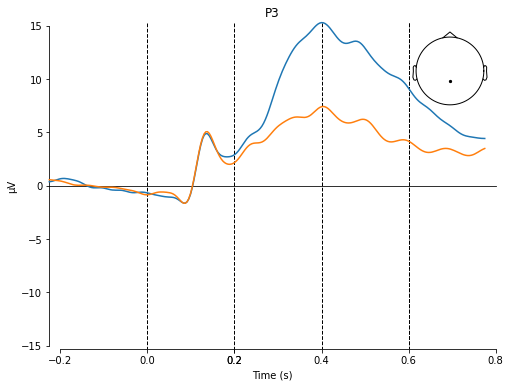

Identifying common channels ...
Identifying common channels ...


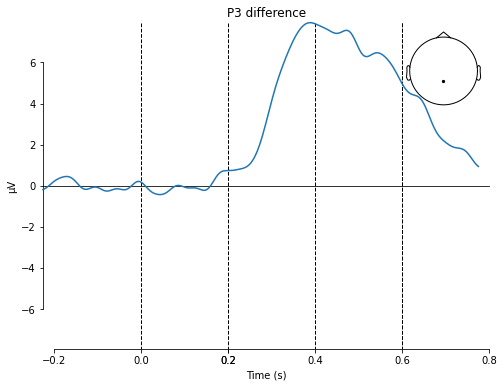

[<Figure size 576x432 with 2 Axes>]

In [33]:
# compare evoked to the literature
# evoked_target_combined.plot()
# evoked_distractor_combined.plot()
mne.viz.plot_compare_evokeds([evoked_target_combined, evoked_distractor_combined],
                             legend=False,
                             vlines=[0.,0.2,0.4,0.6,0.6,0.8],title="P3")

evoked_target_grand_avg = mne.grand_average(evoked_target_dump)
evoked_distractor_grand_avg = mne.grand_average(evoked_distractor_dump)

evoked_difference_grand_avg = mne.combine_evoked([evoked_target_grand_avg, evoked_distractor_grand_avg], weights=[1, -1])

mne.viz.plot_compare_evokeds([evoked_difference_grand_avg],
                             legend=False,
                             vlines=[0.,0.2,0.4,0.6,0.6,0.8],title="P3 difference")


![Parent and difference ERPs from ERP core table 2](img/grand_avg_parent_difference_ERP_tab2_core.png)

Qualitatively, this looks correct. My effect starts a bit earlier and ends a bit later. This could be due to not excluding as many (maybe) artifical subjects as ERP core.
I initially had some problems before shifting correctly with the monitor delay.

In [34]:
diff_filtered = evoked_difference_grand_avg.filter(l_freq=None,h_freq=20,verbose=0)

_, peak_lat, peak_amp = diff_filtered.get_peak(tmin=0.25, tmax=0.50, mode='pos', return_amplitude=True)

print(f"peak latency (ms): {peak_lat * 10**3}")
print(f"peak amplitude (microV): {peak_amp * 10**6}")

peak latency (ms): 388.0625
peak amplitude (microV): 7.923930476108683


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


The documented ERP difference waveform (standard deviation in parentheses), averaged across all participants, reported by Kappenman et al. (2021) is reported to be the following:
- mean amplitude ($\mu V$): $6.29 (3.39)$
- peak amplitude ($\mu V$): $10.15 (4.53)$
- peak latency (ms): $408.89 (70.48)$
- onset latency (ms): $327.44 (61.98)$

Which is far more different than I would have expected from only looking at the plots

In [35]:
features = ['avg_peak_latency', 'avg_response_time', 'avg_peak_amplitude','mean_amplitude']
condition_rare = subjects_df.loc[(subjects_df['condition'] == 'target')].set_index('subject_id')[features]
condition_freq = subjects_df.loc[(subjects_df['condition'] == 'distractor')].set_index('subject_id')[features]

diff_df = condition_rare.sub(condition_freq)
diff_df

avg_peak_latency  avg_response_time  avg_peak_amplitude  \
subject_id                                                            
27                       0.0           0.047532            0.000003   
4                  -0.011719           0.041337            0.000005   
22                  0.027344           0.086713            0.000003   
2                   0.035156           0.105273            0.000021   
19                  0.070312           0.012092            0.000008   
32                 -0.011719           0.074286            0.000009   
23                  0.027344           0.057599            0.000014   
18                  0.039062           0.021677            0.000009   
38                  0.007812           0.084222            0.000005   
20                 -0.042969           0.030821            0.000002   
3                  -0.046875          -0.032214            0.000012   
9                  -0.019531          -0.022747            0.000003   
35                  0.011719           0.027933            0.000004   
31                 -0.003906           0.043976            0.000008   
40                 -0.023438           0.070623            0.000014   
12                  0.003906           0.040969            0.000007   
5                  -0.011719            0.00742            0.000007   
28                  0.132812          -0.029185            0.000006   
37                  0.097656           0.040702            0.000015   
1                   0.109375           0.125946            0.000006   
24                  0.003906           0.046842             0.00001   
17                  0.003906          -0.023152            0.000007   
33                       0.0           0.015644            0.000008   
21                     0.125           0.057368            0.000006   
13                       0.0           0.072179            0.000003   
11                  0.003906           0.027404            0.000005   
25                 -0.015625           0.036791             0.00001   
29                 -0.003906           0.063688            0.000014   
30                  0.046875           0.095918            0.000005   
26                 -0.003906           0.025059            0.000007   
34                  0.167969           0.092821            0.000009   
14                  0.082031            0.11095            0.000003   
8                  -0.066406           0.060712            0.000006   
7                   0.019531           0.037167            0.000008   
15                  0.015625           0.018149            0.000001   
16                  0.136719           0.110339             0.00001   
39                  0.140625           0.017081            0.000008   
36                    0.0625           0.041138            0.000003   

            mean_amplitude  
subject_id                  
27                0.000003  
4                 0.000006  
22                0.000005  
2                 0.000019  
19                0.000006  
32                0.000008  
23                0.000011  
18                0.000009  
38                0.000006  
20                0.000001  
3                 0.000011  
9                 0.000002  
35                0.000006  
31                0.000007  
40                0.000013  
12                0.000008  
5                 0.000003  
28                0.000006  
37                0.000013  
1                 0.000007  
24                0.000008  
17                0.000004  
33                0.000003  
21                0.000005  
13                0.000004  
11                0.000005  
25                 0.00001  
29                0.000012  
30                0.000008  
26                0.000005  
34                 0.00001  
14                0.000002  
8                 0.000006  
7                 0.000004  
15                0.000002  
16                0.000007  
39                0.000007  
36                0.000004

Across participants:

![difference_waveforms_across_participants](img/difference_waveforms_tab3_suppl.png)

### reaction time

In [36]:
np.mean(subjects_df['avg_response_time']) *10e3

3976.817240958527

Mean reaction time and accuracy for each trial type:
- rare (ms): $424.57 (67.67)$ with $89.81 \% (7.94)$
- frequent (ms): $378.08 (66.03)$ with $98.90 \% (1.51)$

## Plot

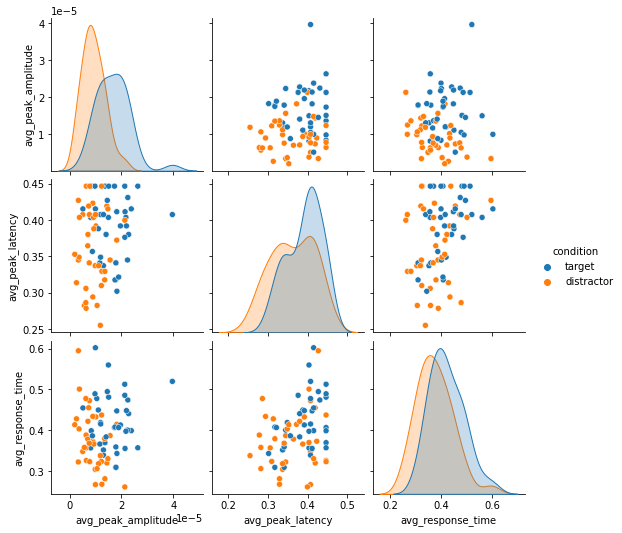

In [37]:
sns.pairplot(subjects_df, vars=['avg_peak_amplitude','avg_peak_latency','avg_response_time'],
            diag_kind='kde',
            hue='condition')
            # hue='subject_id', palette=sns.color_palette("hls", 38)) # change according to number of subjects

We see that the average peak amplitude is higher for the target than for the distractor. This is as expected. The response time for the target seems to be a bit higher than for the distractor, but we can study this more in detail:

In [58]:
print(subjects_df['condition'].dtype)
print(subjects_df['avg_peak_amplitude'].dtype)
ax = sns.violinplot(data=subjects_df, x="condition", y="avg_peak_amplitude",
                    palette="muted",split=True)
plt.show()
ax1 = sns.violinplot(y="avg_response_time", x="condition",
                    data=subjects_df, palette="muted", split=True)
# in my last run it broke here, I really don't understand why...

string
Float64


ValueError: object arrays are not supported

I do not understand this error, there seems to be a problem with the datatypes of my dataframe. But before it worked and I tried a lot... It is not really different from the examples in the docs, oof.

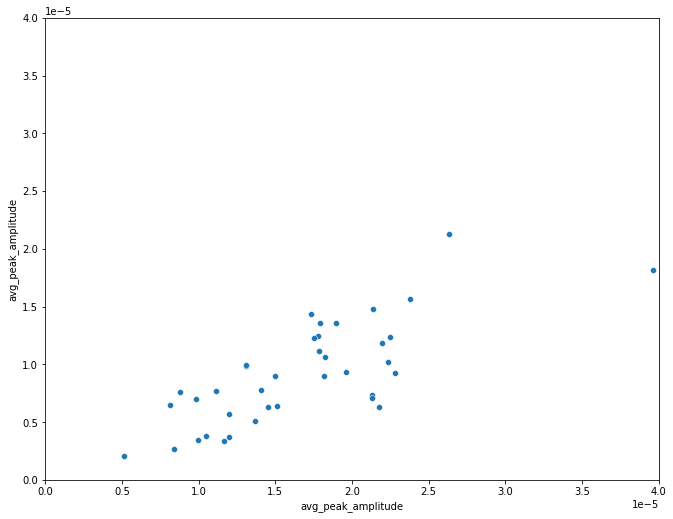

In [41]:
fig, ax = plt.subplots(figsize=(11, 8.5))
sns.scatterplot(x=condition_rare['avg_peak_amplitude'], y=condition_freq['avg_peak_amplitude'], ax=ax)
# plt.plot([0.,0.],[4e-5,4e-5], linewidth=2, color='r')
# X = np.arange(0.,4e-5,1e-5)
sns.lineplot(x=[0.,0.],y=[4e-5,4e-5], linewidth=2, color='r', ax=ax)
ax.set(xlim=(0.,4e-5))
ax.set(ylim=(0.,4e-5))
plt.show()

As all points are in the lower diagonal of the plot, we can see that the target peak amplitude is greater than the distractor peak amplitude.

## save the results

As I am now confident in my results, I write them to the results folder to ease the next steps and for reproduceability.

In [42]:
filepath_target_grand_avg = f"{configuration.path_results}/target_grandavg_evoked-ave.fif"
filepath_distractor_grand_avg = f"{configuration.path_results}/distractor_grandavg_evoked-ave.fif"
filepath_difference_grand_avg = f"{configuration.path_results}/difference_grandavg_evoked-ave.fif"
mne.write_evokeds(filepath_target_grand_avg, evoked_target_grand_avg, overwrite=True)
mne.write_evokeds(filepath_distractor_grand_avg, evoked_distractor_grand_avg, overwrite=True)
mne.write_evokeds(filepath_difference_grand_avg, evoked_difference_grand_avg, overwrite=True)

filepath_metadata = f"{configuration.path_results}/subjects_dataframe.csv"
subjects_df.to_csv(filepath_metadata)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


## statistics

I now apply a permutation t-test on the data to see for which sensors over which interval the signal is significant. 
[Tutorial: Permutation t-test on source data with spatio-temporal clustering](https://mne.tools/stable/auto_tutorials/stats-source-space/20_cluster_1samp_spatiotemporal.html)

In [53]:
# data: (n_samples, n_tests)

X = np.column_stack((condition_rare['mean_amplitude'].to_numpy(dtype='float64'), condition_freq['mean_amplitude'].to_numpy(dtype='float64')))

T0, p_values, H0 = mne.stats.permutation_t_test(X, configuration.n_permutations, # If n_permutations >= 2**n_samples then the exact test is performed
                                                seed = configuration.seed_ttest)

print(f"T0: {T0}, p_values: {p_values}, H0: {H0}")

# histogram
fig, ax = plt.subplots()
ax.hist(H0, bins=100)
ax.axvline(T0[0], ls='-')
ax.axvline(T0[1], ls='-')
plt.show()

Permuting 4999 times...
T0: [14.15669299 10.90658816], p_values: [0.0002 0.0002], H0: [1.20486640e-02 3.18250135e-02 3.26751723e-02 ... 3.53392525e+00
 3.58775190e+00 1.41566930e+01]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


As the p-values are lower than $0.05$ we can see that the difference is significant.